In this kernel we will train a segmention model using 450 fluke masks provided by [Dene](http://https://www.kaggle.com/dene33). I was a little bit skeptical about segmenting flukes mainly because you loose the **sea** information. If there was  some correlation between the sea waves and the classes of whales then segmentation would rule this out. However, I gave it a try (don't tested it yet in my models). 

I will use models from the great repo [segmentation_models](http://https://github.com/qubvel/segmentation_models) (thank you [Pavel](https://www.kaggle.com/pavel92) for the great work). The whole task  is a straightforward single class segmentation and hopefully 450 fluke  masks would be enought  to generalize to the whole train and test set.

In [1]:
import sys
sys.executable

'/anaconda/envs/kerasgpu/bin/python'

In [2]:
import numpy as np
import pandas as pd

seed = 66
np.random.seed(seed)
import cv2
import json
import glob
import os
from tqdm import *
from shutil  import copyfile, rmtree 


from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, SpatialDropout2D, Input
from tensorflow.keras import applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

import tensorflow.keras as keras
import segmentation_models as sm

from tqdm import tqdm_notebook, tqdm

Segmentation Models: using `tf.keras` framework.


In [3]:
TRAIN_PATH = '../input/train/'
TEST_PATH = '../input/test/'
MASK_PATH = '../input/masks/'
WC_PATH = '../input/whalechallenge/'

Let us parse the 450  intial masks (courtesy of **Dene**)

In [4]:
mask_files = os.listdir(MASK_PATH)
# mask_files = [m for m in mask_files if 'mask' in m]
X = []
M = []
for mask_file in mask_files:
    img = cv2.imread(TRAIN_PATH + mask_file)
    mask = cv2.imread(MASK_PATH + mask_file, 0)
    mask[mask>108]= 255
    mask[mask<=108]= 0
    X.append(img)
    M.append(mask)

X = np.array(X)
M = np.array(M)


In [5]:
M[9].shape

(772, 1050)

In [6]:
img_files = os.listdir(WC_PATH)

WC = []
for img_file in img_files:
    img = cv2.imread(WC_PATH + img_file)
    WC.append(img)
WC = np.array(WC)

In [7]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, RandomGamma, Rotate,IAAAffine
)

In [8]:
aug_null = Compose([])
aug = Compose([ 
    Blur(p=0.5, blur_limit=2),
    IAAAffine(p=0.5, shear=5),
    HorizontalFlip(p=0.5),              
    #VerticalFlip(p=0.5),              
    Rotate(limit=5, p=0.3),
    #CLAHE(p=0.3),
    RandomContrast(p=0.2, limit=0.1),
    RandomBrightness(p=0.2, limit=0.1),
    #RandomGamma(p=0.2, gamma_limit=(90, 110))
])


Extending keras.utils.Sequence structure can be really handy. It provides multithreaded access and ensures each input image will be considered exactly one time per epoch.

In [9]:

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, M, batch_size=32,
                 dim=(299,299),  shuffle=True, 
                 preprocess_input=preprocess_input, 
                 aug=aug_null, min_mask=2 ):
        'Initialization'
        self.X = X
        self.M = M
        self.batch_size = batch_size
        self.n_classes = 1
        self.shuffle = shuffle
        self.preprocess_input = preprocess_input
        self.aug = aug
        self.on_epoch_end()
        self.dim = dim

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor((len(self.X) / self.batch_size) / 1) )

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        
        end_index = min((index+1)*self.batch_size, len(self.indexes))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]


        # Generate data
        X, Y = self.__data_generation(indexes)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        batch_size = len(indexes)
        
        # Initialization
        XX = np.empty((batch_size, self.dim[1], self.dim[0], 3), dtype='float32')
        YY = np.empty((batch_size, self.dim[1], self.dim[0], 1), dtype='float32')

        # Generate data
        for i, ID in enumerate(indexes):
            # Store sample
            img = self.X[ID]
            if img.shape[0] != self.dim[0]:
                img = cv2.resize(img, self.dim, cv2.INTER_CUBIC)
            mask = self.M[ID]
            if mask.shape[0] != self.dim[0]:
                mask = cv2.resize(mask, self.dim, cv2.INTER_AREA)
            
            # Store class
            augmented = self.aug(image=img, mask=mask)
            aug_img = augmented['image']
            aug_mask = augmented['mask']
            aug_mask = np.expand_dims(aug_mask, axis=-1)
            aug_mask = aug_mask/255
            
            assert (np.max(aug_mask)<= 1.0 and  np.min(aug_mask) >= 0)
            aug_mask[aug_mask>0.5] = 1
            aug_mask[aug_mask<0.5] = 0
            
            YY[i,] = aug_mask.astype('float32')
            XX[i,] = aug_img.astype('float32')
    
       
        XX = self.preprocess_input(XX)
            
        return XX, YY

We define the default preprocessing for resnet architectures and create train and validation generators (`keras.utils.Sequence`) 

In [10]:
training_generator = DataGenerator(X[:450], M[:450], batch_size=16,  dim=(384, 192), aug=aug, 
                                   preprocess_input=preprocess_input)
valid_genarator = DataGenerator(X[450:], M[450:], batch_size=16, dim=(384, 192), aug=aug_null, 
                                preprocess_input=preprocess_input, shuffle=False)

In [11]:
x, y= training_generator[7]
np.max(x), x.shape, y.shape, np.max(y), np.unique(y)

(255.0,
 (16, 192, 384, 3),
 (16, 192, 384, 1),
 1.0,
 array([0., 1.], dtype=float32))

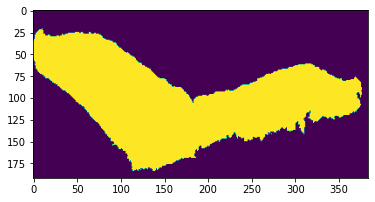

In [12]:
plt.imshow(y[2, ..., 0])
plt.show()

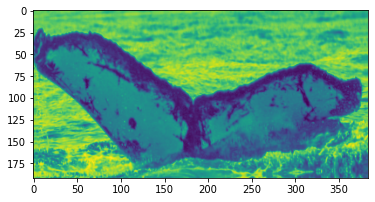

In [13]:
plt.imshow(x[2, ..., 0])
plt.show()

In [14]:
from segmentation_models import Unet, FPN

model = Unet(backbone_name='resnet34', encoder_weights='imagenet', activation='sigmoid', classes=1)


Trivial segmentation stuff. Dice coefficient and binary cross entropy loss united.

In [15]:
import ipdb
def dice_coeff_L(y_true, y_pred):
    smooth = 1.
    y_pred_sig = tf.nn.sigmoid(y_pred)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred_sig)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_coeff(y_true, y_pred):
#     ipdb.set_trace()
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

Let's train the model to see what we can get.

In [16]:
training_generator = DataGenerator(X[:400], M[:400], batch_size=16,  dim=(384, 192), aug=aug, 
                                   preprocess_input=preprocess_input)
valid_genarator = DataGenerator(X[400:], M[400:], batch_size=16, dim=(384, 192), aug=aug_null, 
                                preprocess_input=preprocess_input, shuffle=False)

model.compile(optimizer=Adam(lr=0.001),
          loss=bce_dice_loss,
          metrics=[dice_coeff])

epochs = 40

early_stopping = EarlyStopping(patience=10, verbose=1, monitor='val_dice_coeff', mode='max')
model_checkpoint = ModelCheckpoint("fpnresnet34_384_{epoch:02d}-{val_loss:.3f}-{val_dice_coeff:.3f}.hdf5", 
                                   save_best_only=True, 
                                   save_weights_only=True, 
                                   monitor='val_dice_coeff', verbose=1, mode='max', period=2)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.000001, verbose=1, monitor='val_dice_coeff', mode='max')

 
history = model.fit_generator( training_generator,
                             validation_data=valid_genarator,
                             epochs=epochs,
                             callbacks=[ reduce_lr, early_stopping, model_checkpoint], 
                             verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 3 steps
Epoch 1/40
25/25 [==============================] - 25s 1s/step - loss: 0.7266 - dice_coeff: 0.6411 - val_loss: 165.0974 - val_dice_coeff: 0.4227
Epoch 2/40
24/25 [===========================>..] - ETA: 0s - loss: 0.3148 - dice_coeff: 0.8264
Epoch 00002: val_dice_coeff improved from -inf to 0.50661, saving model to fpnresnet34_384_02-18.761-0.507.hdf5
25/25 [==============================] - 14s 579ms/step - loss: 0.3111 - dice_coeff: 0.8282 - val_loss: 18.7613 - val_dice_coeff: 0.5066
Epoch 3/40
25/25 [==============================] - 14s 567ms/step - loss: 0.1860 - dice_coeff: 0.8983 - val_loss: 1.9210 - val_dice_coeff: 0.6633
Epoch 4/40
24/25 [===========================>..] - ETA: 0s - loss: 0.1357 - dice_coeff: 0.9283
Epoch 00004: val_dice_coeff improved from 0.50661 to 0.65457, saving model to fpnresnet34_384_04-2.

Epoch 33/40
24/25 [===========================>..] - ETA: 0s - loss: 0.0434 - dice_coeff: 0.9801
Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
25/25 [==============================] - 14s 577ms/step - loss: 0.0434 - dice_coeff: 0.9801 - val_loss: 0.0670 - val_dice_coeff: 0.9719
Epoch 34/40
24/25 [===========================>..] - ETA: 0s - loss: 0.0421 - dice_coeff: 0.9805
Epoch 00034: val_dice_coeff did not improve from 0.97400
25/25 [==============================] - 14s 577ms/step - loss: 0.0421 - dice_coeff: 0.9805 - val_loss: 0.0662 - val_dice_coeff: 0.9724
Epoch 35/40
25/25 [==============================] - 14s 578ms/step - loss: 0.0418 - dice_coeff: 0.9807 - val_loss: 0.0674 - val_dice_coeff: 0.9718
Epoch 36/40
24/25 [===========================>..] - ETA: 0s - loss: 0.0408 - dice_coeff: 0.9810
Epoch 00036: val_dice_coeff did not improve from 0.97400
25/25 [==============================] - 14s 577ms/step - loss: 0.0415 - dice_coeff: 0.9809 - v

This is not good software engineering, but  I was in a hurry so I copied/modified `DataGenerator` to create the `TestDataGenerator` class that also extends `keras.utils.Sequence` but ignores masks. This will be used for inference only. 

In [19]:
aug_null = Compose([])


class TestDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, batch_size=32,
                 dim=(299,299),  shuffle=True, 
                 preprocess_input=preprocess_input, 
                 aug=aug_null, min_mask=2 ):
        'Initialization'
        self.X = X
        self.batch_size = batch_size
        self.n_classes = 1
        self.shuffle = shuffle
        self.preprocess_input = preprocess_input
        self.aug = aug
        self.dim = dim
        self.on_epoch_end()

    def set_aug(self, aug):
        self.aug = aug
        self.on_epoch_end()
      
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor((len(self.X) / self.batch_size) / 1) )

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        
        end_index = min((index+1)*self.batch_size, len(self.indexes))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs

        # Generate data
        xx = self.__data_generation(indexes)

        return xx

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        batch_size = len(indexes)
        
        # Initialization
        XX = np.empty((batch_size, self.dim[1], self.dim[0], 3), dtype='float32')

        # Generate data
        for i, ID in enumerate(indexes):
            # Store sample
            img = self.X[ID]
            if img.shape[0] != self.dim[0]:
                img = cv2.resize(img, self.dim, cv2.INTER_CUBIC)
            
            
            # Store class
            augmented = self.aug(image=img)
            aug_img = augmented['image']
            if aug_img.shape[1] != self.dim[1]:
                aug_img = cv2.resize(aug_img, self.dim, cv2.INTER_CUBIC)
            XX[i,] = aug_img.astype('float32')
    
       
        XX = self.preprocess_input(XX)

        return XX

The model is trained... Let us see some validation cases. Using the handy generator with `shuffle=False` we can easily perform a simple test time augmentattion.

In [20]:
null_aug = Compose([])
test_generator = TestDataGenerator(WC, batch_size=16, aug=null_aug, preprocess_input=preprocess_input, dim=(384, 192), 
                               shuffle=False)
preds = model.predict_generator(test_generator, verbose=1)

flip_aug = Compose([HorizontalFlip(p=1.0) ])
test_generator = TestDataGenerator(WC, batch_size=16, aug=flip_aug, preprocess_input=preprocess_input,  dim=(384, 192), shuffle=False)
preds_hflip = model.predict_generator(test_generator, verbose=1)

blur_aug = Compose([Blur(p=1.0)])
test_generator = TestDataGenerator(WC, batch_size=16, aug=blur_aug, preprocess_input=preprocess_input,  dim=(384, 192), shuffle=False)
preds_blur = model.predict_generator(test_generator, verbose=1)


50/50 [==============================] - 8s 167ms/step


In [21]:
TARGET_VAL = []
for i in range(len(preds)):
    pp = (preds[i])# + np.fliplr(preds_hflip[i]) + preds_blur[i])/3
    TARGET_VAL.append(pp)

TARGET_VAL = np.array(TARGET_VAL)  

In [ ]:
# null_aug = Compose([])
# valid_genarator = DataGenerator(X[450:], M[450:], batch_size=16, aug=null_aug, preprocess_input=preprocess_input, dim=(384, 192), 
#                                shuffle=False)
# preds = model.predict_generator(valid_genarator, verbose=1)

# flip_aug = Compose([HorizontalFlip(p=1.0) ])
# valid_genarator = DataGenerator(X[450:], M[450:], batch_size=16, aug=flip_aug, preprocess_input=preprocess_input,  dim=(384, 192), shuffle=False)
# preds_hflip = model.predict_generator(valid_genarator, verbose=1)

# blur_aug = Compose([Blur(p=1.0)])
# valid_genarator = DataGenerator(X[450:], M[450:], batch_size=16, aug=blur_aug, preprocess_input=preprocess_input,  dim=(384, 192), shuffle=False)
# preds_blur = model.predict_generator(valid_genarator, verbose=1)

# TARGET_VAL = []
# for i in range(len(preds)):
#     pp = (preds[i])# + np.fliplr(preds_hflip[i]) + preds_blur[i])/3
#     TARGET_VAL.append(pp)

# TARGET_VAL = np.array(TARGET_VAL)  

The nice side effect from segmenting the whale flukes is that we can get tight bounding boxes as well. In the figure bellow we keep a tight bounding box and only pixels that correspond to the mask. There are several ways to move from here:
### 1. Draw colored flukes on white background

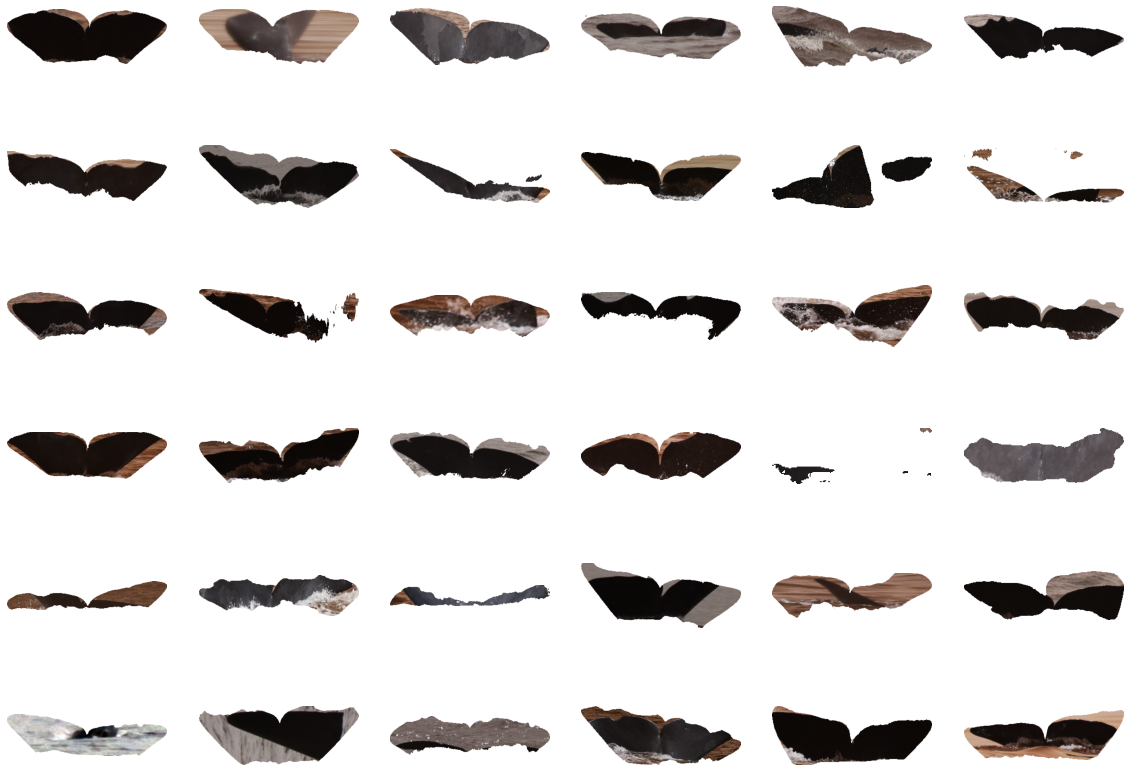

In [22]:
SIZE = 384
f, axarr = plt.subplots(6, 6)
f.set_figwidth(20)
f.set_figheight(15)
kernel = np.ones((3,3),np.uint8)

for i in range(0, 36):
    img =  cv2.resize(WC[450+i], (384, 192))
    mask = ((TARGET_VAL[i, ..., 0]) > 0.25).astype('uint8')
    back = ((TARGET_VAL[i, ..., 0]) <= 0.25).astype('uint8')

    img = np.stack([img[..., j] * mask + back*255 for j in range(3)], axis=-1)

    contours,hierarchy = cv2.findContours(mask, 1, 2)
  # Cycle through contours and add area to array
    areas = []
    for c in contours:
        areas.append(cv2.contourArea(c))

    # Sort array of areas by size
    sorted_areas = sorted(zip(areas, contours), key=lambda x: x[0], reverse=True)
    title = str(len(sorted_areas)) 
    
    cnt = sorted_areas[0][1]
    x1,y1,w,h = cv2.boundingRect(cnt)
    x2 = x1 + w
    y2 = y1 + h
    
    for j in range(1, len(sorted_areas)):
        cnt = sorted_areas[j][1]
        tx1,ty1,tw,th = cv2.boundingRect(cnt)
        tx2 = tx1 + tw
        ty2 = ty1 + th
        x1 = min(x1, tx1)
        y1 = min(y1, ty1)
        x2 = max(x2, tx2)
        y2 = max(y2, ty2)
    
    x = x1
    y = y1
    w = x2-x1
    h = y2-y1


    img_cropped = img[y:y+h, x:x+w]
    axarr[int(i/6), i%6].imshow(img_cropped, cmap='gray')
    axarr[int(i/6), i%6].axis('off')
plt.show()

### 2. Draw colored flukes on black background

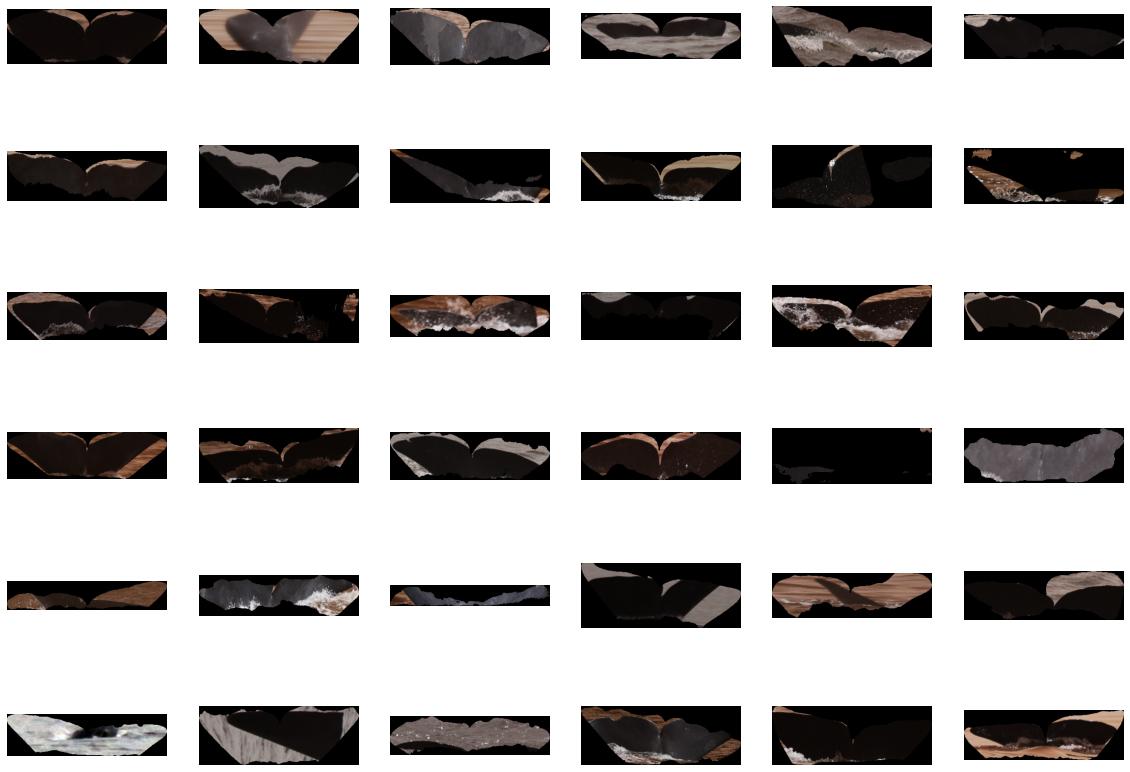

In [23]:
SIZE = 384
f, axarr = plt.subplots(6, 6)
f.set_figwidth(20)
f.set_figheight(15)
kernel = np.ones((3,3),np.uint8)

for i in range(0, 36):
    img =  cv2.resize(WC[450+i], (384, 192))
    mask = ((TARGET_VAL[i, ..., 0]) > 0.25).astype('uint8')

    img = np.stack([img[..., j] * mask  for j in range(3)], axis=-1)

    contours,hierarchy = cv2.findContours(mask, 1, 2)
  # Cycle through contours and add area to array
    areas = []
    for c in contours:
        areas.append(cv2.contourArea(c))

    # Sort array of areas by size
    sorted_areas = sorted(zip(areas, contours), key=lambda x: x[0], reverse=True)
    title = str(len(sorted_areas)) 
    
    cnt = sorted_areas[0][1]
    x1,y1,w,h = cv2.boundingRect(cnt)
    x2 = x1 + w
    y2 = y1 + h
    
    for j in range(1, len(sorted_areas)):
        cnt = sorted_areas[j][1]
        tx1,ty1,tw,th = cv2.boundingRect(cnt)
        tx2 = tx1 + tw
        ty2 = ty1 + th
        x1 = min(x1, tx1)
        y1 = min(y1, ty1)
        x2 = max(x2, tx2)
        y2 = max(y2, ty2)
    
    x = x1
    y = y1
    w = x2-x1
    h = y2-y1


    img_cropped = img[y:y+h, x:x+w]
    axarr[int(i/6), i%6].imshow(img_cropped, cmap='gray')
    axarr[int(i/6), i%6].axis('off')
plt.show()

### 3. Draw colored flukes and keep the sea (tight bounding box)

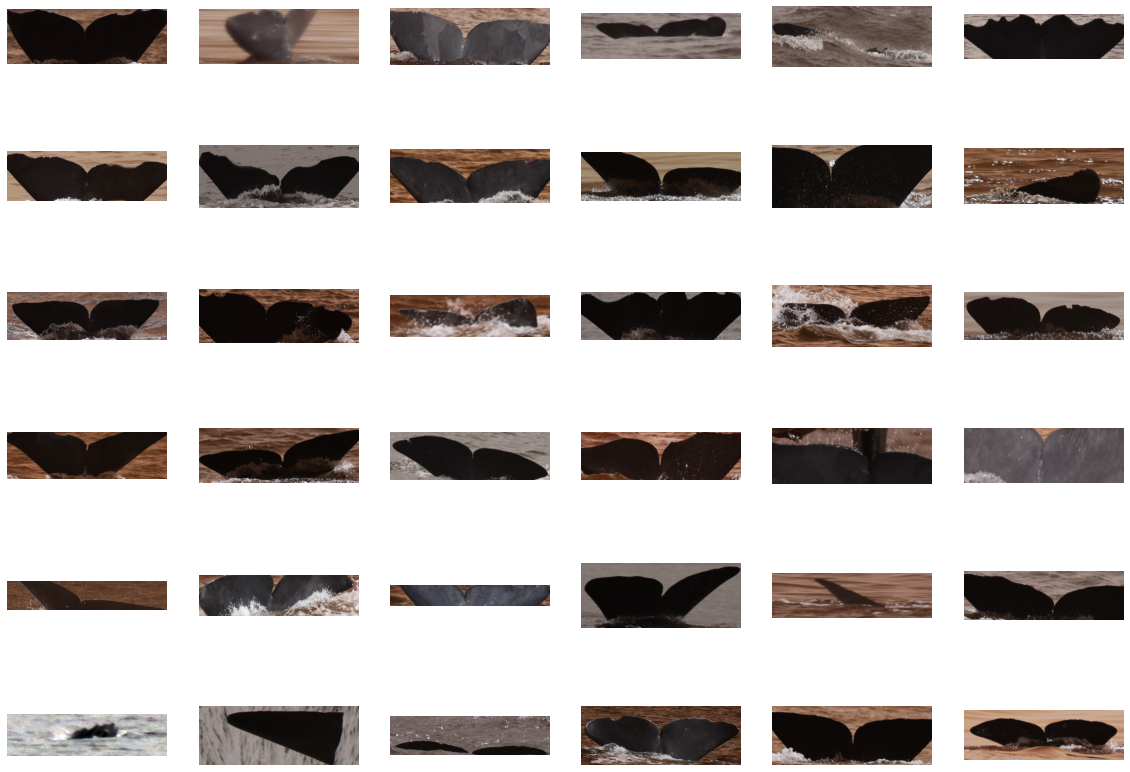

In [24]:
SIZE = 384
f, axarr = plt.subplots(6, 6)
f.set_figwidth(20)
f.set_figheight(15)
kernel = np.ones((3,3),np.uint8)

for i in range(0, 36):
    img =  cv2.resize(WC[450+i], (384, 192))
    mask = ((TARGET_VAL[i, ..., 0]) > 0.25).astype('uint8')

    img = np.stack([img[..., j]  for j in range(3)], axis=-1)

    contours,hierarchy = cv2.findContours(mask, 1, 2)
  # Cycle through contours and add area to array
    areas = []
    for c in contours:
        areas.append(cv2.contourArea(c))

    # Sort array of areas by size
    sorted_areas = sorted(zip(areas, contours), key=lambda x: x[0], reverse=True)
    title = str(len(sorted_areas)) 
    
    cnt = sorted_areas[0][1]
    x1,y1,w,h = cv2.boundingRect(cnt)
    x2 = x1 + w
    y2 = y1 + h
    
    for j in range(1, len(sorted_areas)):
        cnt = sorted_areas[j][1]
        tx1,ty1,tw,th = cv2.boundingRect(cnt)
        tx2 = tx1 + tw
        ty2 = ty1 + th
        x1 = min(x1, tx1)
        y1 = min(y1, ty1)
        x2 = max(x2, tx2)
        y2 = max(y2, ty2)
    
    x = x1
    y = y1
    w = x2-x1
    h = y2-y1


    img_cropped = img[y:y+h, x:x+w]
    axarr[int(i/6), i%6].imshow(img_cropped, cmap='gray')
    axarr[int(i/6), i%6].axis('off')
plt.show()

### 4. Draw grayscale flukes in white background

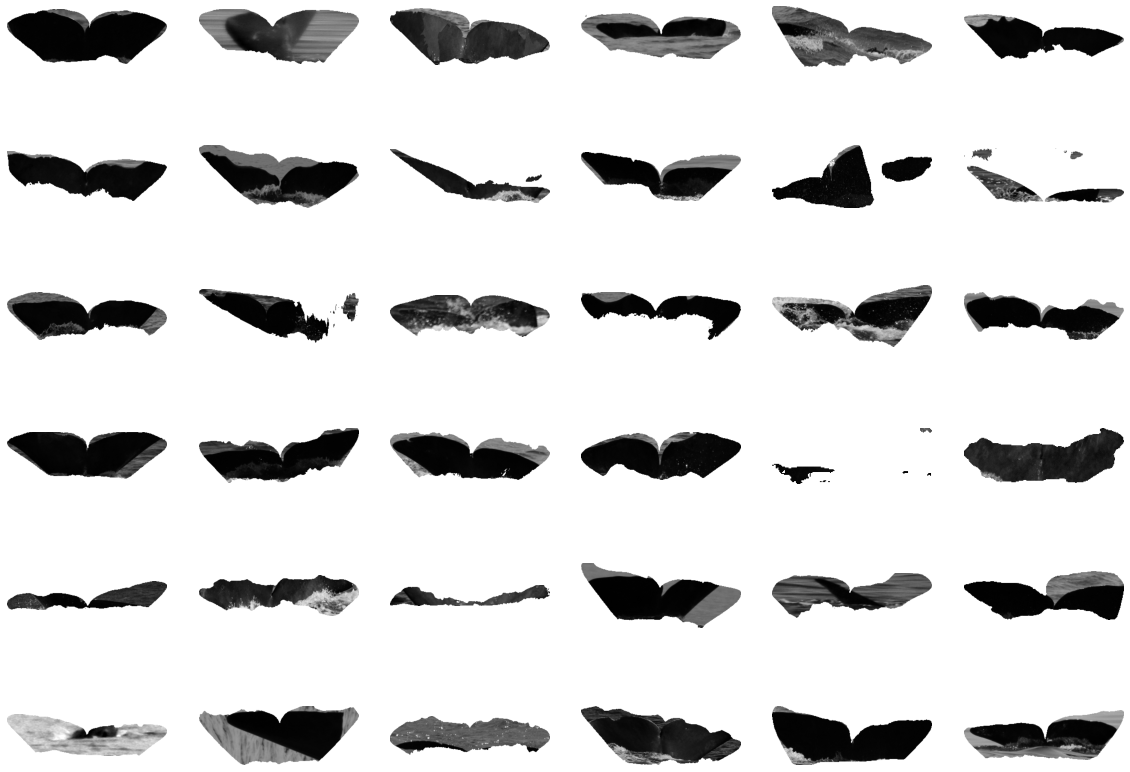

In [25]:
SIZE = 384
f, axarr = plt.subplots(6, 6)
f.set_figwidth(20)
f.set_figheight(15)
kernel = np.ones((3,3),np.uint8)

for i in range(0, 36):
    img =  cv2.resize(WC[450+i], (384, 192))
    img =  cv2.cvtColor(img, cv2.cv2.COLOR_BGR2GRAY)
    mask = ((TARGET_VAL[i, ..., 0]) > 0.25).astype('uint8')
    back = ((TARGET_VAL[i, ..., 0]) <= 0.25).astype('uint8')
    img = img * mask + back*255

    contours,hierarchy = cv2.findContours(mask, 1, 2)
  # Cycle through contours and add area to array
    areas = []
    for c in contours:
        areas.append(cv2.contourArea(c))

    # Sort array of areas by size
    sorted_areas = sorted(zip(areas, contours), key=lambda x: x[0], reverse=True)
    title = str(len(sorted_areas)) 
    
    cnt = sorted_areas[0][1]
    x1,y1,w,h = cv2.boundingRect(cnt)
    x2 = x1 + w
    y2 = y1 + h
    
    for j in range(1, len(sorted_areas)):
        cnt = sorted_areas[j][1]
        tx1,ty1,tw,th = cv2.boundingRect(cnt)
        tx2 = tx1 + tw
        ty2 = ty1 + th
        x1 = min(x1, tx1)
        y1 = min(y1, ty1)
        x2 = max(x2, tx2)
        y2 = max(y2, ty2)
    
    x = x1
    y = y1
    w = x2-x1
    h = y2-y1


    img_cropped = img[y:y+h, x:x+w]
    axarr[int(i/6), i%6].imshow(img_cropped, cmap='gray')
    axarr[int(i/6), i%6].axis('off')
plt.show()

A small explanation about this part of code
   ```
   contours,hierarchy = cv2.findContours(mask, 1, 2)
    areas = []
    for c in contours:
        areas.append(cv2.contourArea(c))

    # Sort array of areas by size
    sorted_areas = sorted(zip(areas, contours), key=lambda x: x[0], reverse=True)
    title = str(len(sorted_areas)) 
    
    cnt = sorted_areas[0][1]
    x1,y1,w,h = cv2.boundingRect(cnt)
    x2 = x1 + w
    y2 = y1 + h
    
    for j in range(1, len(sorted_areas)):
        cnt = sorted_areas[j][1]
        tx1,ty1,tw,th = cv2.boundingRect(cnt)
        tx2 = tx1 + tw
        ty2 = ty1 + th
        x1 = min(x1, tx1)
        y1 = min(y1, ty1)
        x2 = max(x2, tx2)
        y2 = max(y2, ty2)
        ```

I calculate the bouning box of the mask using `cv2.findContours`. In case we have multiple disconnected components in the same mask, the bounding box is calculated using the minimum `x` and `y` and the maximum `x` and `y` of all components, hence the loop. This is the meaning of:
```
    x1 = min(x1, tx1)
    y1 = min(y1, ty1)
    x2 = max(x2, tx2)
    y2 = max(y2, ty2)
   ```
   within the loop.